<a href="https://colab.research.google.com/github/subhradeepbhaumick/CODSOFT/blob/main/codsoft_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **importing libraries**

In [130]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import  MultinomialNB,BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
%matplotlib inline
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [131]:
#Initialize PorterStemmer object for further stemming of words for text pre-processing
stemmer = PorterStemmer()

#Initializing CountVectorizer object for vectorize documents for text pre-processing, 2500 unique most frequent words are taken as features
vectorizer = CountVectorizer(max_features=2500)

# Initialize SMOTE for over-sampling of training data for imbalanced dataset
smote = SMOTE(random_state=42)

# # Stopwords set like "the","and","of"
stop_words = set(stopwords.words("english"))

In [132]:
df= pd.read_csv("/content/spam.csv",encoding='utf-8', encoding_errors='ignore')
print(df)

        v1                                                 v2 Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   
...    ...                                                ...        ...   
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham               Will _ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4  
0           NaN        NaN  
1           NaN        NaN  


In [133]:
df.describe()
df.info()
df.isnull().sum()
df.duplicated().sum()#duplication of data
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## **Data Cleaning**

In [134]:
#Remove duplicate datapoints
df.drop_duplicates(keep='first', inplace=True)

In [135]:
# dropping last 3 columns as unnecessary
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
# renaming the cols
df.rename(columns={'v1':'result', 'v2':'sms'}, inplace=True)

In [136]:
print(df)

     result                                                sms
0       ham  Go until jurong point, crazy.. Available only ...
1       ham                      Ok lar... Joking wif u oni...
2      spam  Free entry in 2 a wkly comp to win FA Cup fina...
3       ham  U dun say so early hor... U c already then say...
4       ham  Nah I don't think he goes to usf, he lives aro...
...     ...                                                ...
5567   spam  This is the 2nd time we have tried 2 contact u...
5568    ham               Will _ b going to esplanade fr home?
5569    ham  Pity, * was in mood for that. So...any other s...
5570    ham  The guy did some bitching but I acted like i'd...
5571    ham                         Rofl. Its true to its name

[5168 rows x 2 columns]


In [141]:
#Converting result column in numerical binary data

df.loc[df['result'] == 'ham', 'result'] = 0  # Set 'ham' to 0
df.loc[df['result'] == 'spam', 'result'] = 1  # Set 'spam' to 1

  # Explicitly convert the 'result' column to integers
df['result'] = df['result'].astype(int)

In [142]:
#Check if imbalanced dataset or not using frequency of individual binary classes
class_freq = df['result'].value_counts()
class_freq

,count
result,
0,4516
1,652


<BarContainer object of 2 artists>

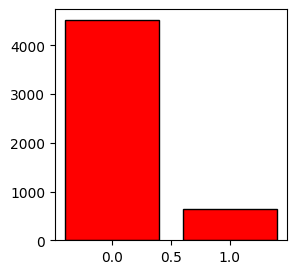

In [143]:
# Plotting frequency of output binary classes
plt.figure(figsize=(3,3))
plt.bar(class_freq.index, class_freq.values, color='red', edgecolor='black')

In [144]:
#data pre-processing
def preprocess_text(text):
    text = re.sub(r"[^\w\s]", "", text)  # Remove special characters
    text = text.lower()#Convert to lowercase
    text = re.sub(r"\s+", " ", text)#Remove extra whitespace
    text = re.sub(r'@\S+', '', text)#removes mentions from the text.
    text = re.sub(r'http\S+', '', text)#removes URLs from the text.
    text = re.sub(r'.pic\S+', '', text)#removes image links (often ending with .pic) from the text.
    text = re.sub(r'[^a-zA-Z+]', ' ', text)#replaces all non-alphanumeric characters (except +) with a space.
    words = nltk.word_tokenize(text)#tokenization-split the cleaned text into individual words or tokens
    text = " ".join([i for i in words if i not in stop_words and len(i) > 2])#remove stop words
    text = re.sub(r"\s+", " ", text).strip()  # Replace multiple spaces with a single space
    text = "".join([i for i in text if i not in string.punctuation])#removes all punctuation from the text

    return text

In [145]:
df['cleaned_sms'] = df['sms'].apply(preprocess_text)

In [146]:
df.head()

,result,sms,cleaned_sms
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis great world...
1,0,Ok lar... Joking wif u oni...,lar joking wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win cup final tkts may te...
3,0,U dun say so early hor... U c already then say...,dun say early hor already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though


In [147]:
#use TF-IDF to convert the preprocessed text into numerical representations
vectorize = TfidfVectorizer()
X = vectorize.fit_transform(df["cleaned_sms"])
y=df["result"]

# Spilt and Train a Model
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size= 0.25, random_state=16)

In [148]:
pd.Series(Y_train).value_counts()

,count
result,
0,3399
1,477


In [149]:
# As dataset is imballanced so resampling(generating new datapoints) using SMOTE resampling technique
X_Resampled, Y_Resampled = smote.fit_resample(X_train, Y_train)
print('Resampled training dataset shape: ', X_Resampled.shape)
print('Resampled binary class output shape: ', Y_Resampled.shape)

Resampled training dataset shape:  (6798, 8047)
Resampled binary class output shape:  (6798,)


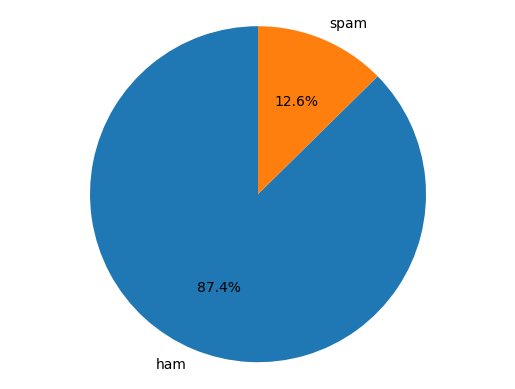

<Figure size 100x100 with 0 Axes>

In [150]:
labels = ['ham', 'spam']
colors = ['#ff9999','#66b3ff']
plt.pie(df['result'].value_counts(), labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.figure(figsize=(1,1))
plt.show()

In [151]:
# Clecking if training data is balanced after resampling for better model training
pd.Series(Y_Resampled).value_counts()

,count
result,
1,3399
0,3399


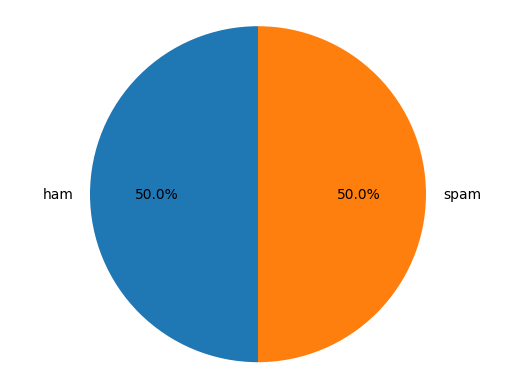

<Figure size 300x300 with 0 Axes>

In [152]:
labels = ['ham', 'spam']
colors = ['#ff9999','#66b3ff']
plt.pie(pd.Series(Y_Resampled).value_counts(), labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.figure(figsize=(3,3))
plt.show()

## **ML Model training**

In [153]:
bnb = BernoulliNB()
mnb = MultinomialNB()
lgc=LogisticRegression()
svc=LinearSVC()

## **Naive Bayes**

In [154]:
bnb.fit(X_Resampled, Y_Resampled)
mnb.fit(X_Resampled, Y_Resampled)

MultinomialNB()

## **Logistic Regression**

In [155]:
lgc.fit(X_Resampled, Y_Resampled)

LogisticRegression()

## **Support Vector Machine**

In [156]:
svc.fit(X_Resampled, Y_Resampled)

LinearSVC()

In [160]:
#Generating predicted output from testing dataset
bernoulliNB_Y_Pred = bnb.predict(X_test)
multinomialNB_Y_Pred = mnb.predict(X_test)
logisticRegression_Y_Pred = lgc.predict(X_test)
linearSVC_Y_Pred = svc.predict(X_test)

## **Predicting and Evaluating model performance**

In [166]:
bernoulliNB_Accuracy = accuracy_score(Y_test, bernoulliNB_Y_Pred)
bernoulliNB_Precision = precision_score(Y_test, bernoulliNB_Y_Pred, pos_label=1)
bernoulliNB_recall_score = recall_score(Y_test, bernoulliNB_Y_Pred, pos_label=1)
bernoulliNB_f1_score = f1_score(Y_test, bernoulliNB_Y_Pred, pos_label=1)
print('bernoulliNB accuracy metric:', bernoulliNB_Accuracy)
print('bernoulliNB precision metric:', bernoulliNB_Precision)
print('bernoulliNB recall metric:', bernoulliNB_recall_score)
print('bernoulliNB f1-score metric:', bernoulliNB_f1_score)

bernoulliNB accuracy metric: 0.978328173374613
bernoulliNB precision metric: 0.9867549668874173
bernoulliNB recall metric: 0.8514285714285714
bernoulliNB f1-score metric: 0.9141104294478528


In [168]:
multinomialNB_Accuracy = accuracy_score(Y_test, multinomialNB_Y_Pred)
multinomialNB_Precision = precision_score(Y_test, multinomialNB_Y_Pred, pos_label=1)
multinomialNB_recall_score = recall_score(Y_test, multinomialNB_Y_Pred, pos_label=1)
multinomialNB_f1_score = f1_score(Y_test, multinomialNB_Y_Pred, pos_label=1)
print('multinomialNB accuracy metric:', multinomialNB_Accuracy)
print('multinomialNB precision metric:', multinomialNB_Precision)
print('multinomialNB recall metric:', multinomialNB_recall_score)
print('multinomialNB f1-score metric:', multinomialNB_f1_score)

multinomialNB accuracy metric: 0.9613003095975232
multinomialNB precision metric: 0.817258883248731
multinomialNB recall metric: 0.92
multinomialNB f1-score metric: 0.8655913978494624


In [170]:
lgc_Accuracy = accuracy_score(Y_test, multinomialNB_Y_Pred)
lgc_Precision = precision_score(Y_test, multinomialNB_Y_Pred, pos_label=1)
lgc_recall_score = recall_score(Y_test, multinomialNB_Y_Pred, pos_label=1)
lgc_f1_score = f1_score(Y_test, multinomialNB_Y_Pred, pos_label=1)
print('logistic regression accuracy metric:', lgc_Accuracy)
print('logistic regression precision metric:', lgc_Precision)
print('logistic regression recall metric:', lgc_recall_score)
print('logistic regression f1-score metric:', lgc_f1_score)

logistic regression accuracy metric: 0.9613003095975232
logistic regression precision metric: 0.817258883248731
logistic regression recall metric: 0.92
logistic regression f1-score metric: 0.8655913978494624


In [172]:
svm_Accuracy = accuracy_score(Y_test, linearSVC_Y_Pred)
svm_Precision = precision_score(Y_test, linearSVC_Y_Pred, pos_label=1)
svm_recall_score = recall_score(Y_test, linearSVC_Y_Pred, pos_label=1)
svm_f1_score = f1_score(Y_test, linearSVC_Y_Pred, pos_label=1)
print('logistic regression accuracy metric:', svm_Accuracy)
print('logistic regression precision metric:', svm_Precision)
print('logistic regression recall metric:', svm_recall_score)
print('logistic regression f1-score metric:', svm_f1_score)

logistic regression accuracy metric: 0.9736842105263158
logistic regression precision metric: 0.9731543624161074
logistic regression recall metric: 0.8285714285714286
logistic regression f1-score metric: 0.8950617283950617
